数値計算して解を求める -> 読み込んでPINNの逆問題を解く

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

#演算子と格子点を出力する
def cheb(N):
    '''Chebyshev polynomial differentiation matrix.
       Ref.: Trefethen's 'Spectral Methods in MATLAB' book.
    '''
    x      = np.cos(np.pi*np.arange(0,N+1)/N)
    if N%2 == 0:
        x[N//2] = 0.0 # only when N is even!
    c      = np.ones(N+1); c[0] = 2.0; c[N] = 2.0
    c      = c * (-1.0)**np.arange(0,N+1)
    c      = c.reshape(N+1,1)
    X      = np.tile(x.reshape(N+1,1), (1,N+1))
    dX     = X - X.T
    D      = np.dot(c, 1.0/c.T) / (dX+np.eye(N+1))
    D      = D - np.diag( D.sum(axis=1) )
    return D,x

#Burgers方程式
def burgers(t, u, nu, D, D2):
    conv = u * D @ u #移流項: D:1階微分
    vis = nu * D2 @ u #粘性項: D2:2階微分
    bur = -conv + vis
    bur[0] = 0 #境界条件
    bur[-1] = 0 #境界条件
    return bur

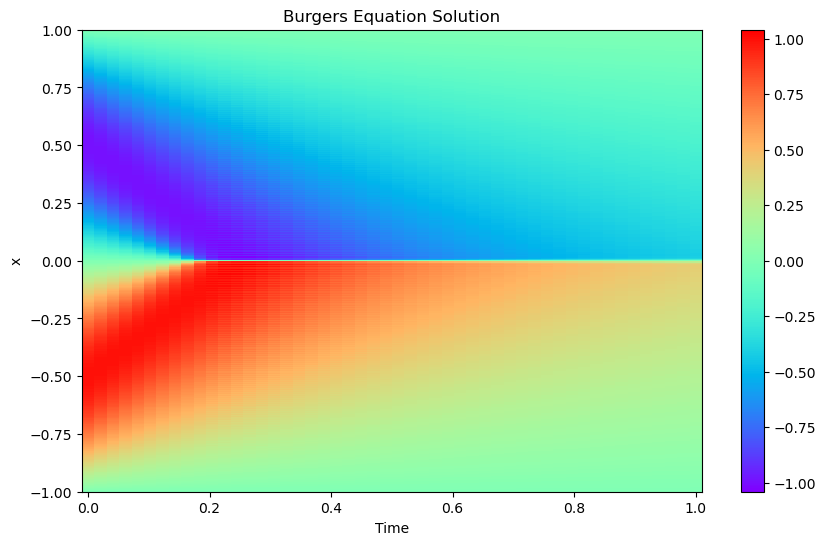

In [12]:
def burgers(t, u, nu, D, D2):
    conv = u * D @ u #移流項: D:1階微分
    vis = nu * D2 @ u #粘性項: D2:2階微分
    bur = -conv + vis
    bur[0] = 0 #境界条件
    bur[-1] = 0 #境界条件
    return bur

N = 600 #格子点数
T = 1#最大時間
t = np.linspace(0, T, 50) #時間
D, x = cheb(N) #D:1階微分演算子、x:x座標
D2 = D @ D #2階微分演算子

#パラメータ
nu = 0.01 / np.pi  #動粘性係数

#初期値
u0 = np.sin(- np.pi * x )

#数値計算
sol_bur = solve_ivp(burgers, [0, T], u0, method='Radau', t_eval=t, args=(nu,D,D2))

#計算結果
u = sol_bur.y

import matplotlib.pyplot as plt
import numpy as np

# tとxのグリッドを作成
T_numerical_burgers, X_numerical_burgers = np.meshgrid(t, x)

# ヒートマップの作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定
plt.pcolormesh(T_numerical_burgers, X_numerical_burgers, u, shading='auto', cmap='rainbow')  # uをヒートマップとして表示
plt.colorbar()  # カラーバーを表示
plt.xlabel('Time')  # x軸のラベル
plt.ylabel('x')  # y軸のラベル
plt.title('Burgers Equation Solution')  # グラフのタイトル
plt.show()  # グラフを表示

## ここから、torchによるPINNの実装

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


In [5]:
criteria = nn.MSELoss()

## PINN Lossの設定
逆問題用のPINNLossの設定。未知パラメータ$v$を含むburgers方程式。  
関数は、未知パラメータ$v$と、$x$と$t$の配列、並びにニューラルネットワークを受け取る。  
受け取った、$(x,t)$でのニューラルネットワークの出力$u$を計算し、そこでの偏導関数の値も計算。
上で定義したcriteriaを使って、二乗誤差を計算・出力  
  
(追記)$x,t$の配列は、たとえば${(x_i,t_i)}_{i=1}^N$の座標点で行うならば、$X=[x_1,...x_N],T=[t_1,...t_N]$のように分ける形（もちろんtensorでautogradもつける。）

In [53]:
def physics_informed_loss(v, x, t, net):
    u = net(x,t)

    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u), 
        retain_graph=True, 
        create_graph=True,
        allow_unused=True
    )[0]
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u), 
        retain_graph=True, 
        create_graph=True,
        allow_unused=True
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs=torch.ones_like(u), 
        retain_graph=True, 
        create_graph=True,
        allow_unused=True
    )[0]
    pinn_loss =  u_t + u * u_x - v * u_xx
    zeros = torch.ones_like(pinn_loss)
    pinn_loss_ = criteria(pinn_loss, zeros)
    return pinn_loss_
        

## 初期・境界・データ点での損失計算
意味は違えど、形は全て一緒（学習時に間違えないように一応関数を分けているだけ。）  
xとtの配列を受け取って、その点でのnetの出力を記録。教師データであるuの間での二乗誤差を出力。

In [29]:
def ic_loss(x,t,net,u_ini):
    u = net(x,t)
    ini_loss = criteria(u,u_ini)
    return ini_loss
def bc_loss(x,t,net,u_bc):
    u = net(x,t)
    bound_loss = criteria(u,u_bc)
    return bound_loss
def data_loss(x, t, net, u_data):
    u = net(x,t)
    data_loss = criteria(u,u_data)
    return data_loss


## 初期条件のサンプリング
初期条件($t=0$)におけるデータ点を返す関数。
X_iniは、$[[x_0,t=0],[x_1,t=0],...[x_n,t=0]]$が入っている。

In [55]:
def ini_sample(ini_sample_size):#300ほど
    x_ini = np.linspace(-1, 1, ini_sample_size)
    X_ini = np.zeros([ini_sample_size, 2])
    X_ini[:,0] = x_ini
    u_ini = -np.sin(np.pi * x_ini)

    X_ini_t = torch.tensor(X_ini, requires_grad=True).float()
    u_ini_t = torch.tensor(u_ini, requires_grad=True).float()

    return X_ini_t, u_ini_t


## 境界でのサンプリング


In [32]:
def bc_sample(bc_sample_size):#200が目安

    x_bc = np.array([-1, 1])
    t_bc = np.linspace(0, 1.0, bc_sample_size)

#x=-1.0における条件
    X_bc1 = np.zeros([bc_sample_size, 2])
    X_bc1[:,0] = -1.0
    X_bc1[:,1] = t_bc

#x=1.0における条件
    X_bc2 = np.zeros([bc_sample_size, 2])
    X_bc2[:,0] = 1.0
    X_bc2[:,1] = t_bc

#stack
    X_bc_stack = np.vstack([X_bc1, X_bc2])
    u_bc_stack = np.zeros(X_bc_stack.shape[0])

    X_bc_t = torch.tensor(X_bc_stack, requires_grad=True).float()
    u_bc_t = torch.tensor(u_bc_stack, requires_grad=True).float().unsqueeze(dim=1)
    return X_bc_t, u_bc_t

In [39]:
# sampling point
def select_collocation_point(sampling_size):
    x_ = np.linspace(-1, 1, 100)
    t_ = np.linspace(0, 1, 100)
    X, T = np.meshgrid(x_, t_, indexing='ij')
    x_flat = X.flatten()
    t_flat = T.flatten()

    random_idx = np.random.choice(np.arange(x_flat.shape[0]), size = sampling_size, replace=False)

# sampling

    x_sampled = x_flat[random_idx]
    t_sampled = t_flat[random_idx]

    X_sampled = np.zeros([sampling_size, 2])
    X_sampled[:,0] = x_sampled
    X_sampled[:,1] = t_sampled

    X_sample_t = torch.tensor(X_sampled, requires_grad=True).float()
    return X_sample_t



In [46]:
# データポイントの設定（逆問題のため）

def data_point_sampling(x, t, u, sampling_size):
    x_data = x.flatten()
    t_data = t.flatten()
    u_data = u.flatten()
    random_idx = np.random.choice(np.arange(x_data.shape[0]), size = sampling_size, replace=False)
    x_data_sampled = x_data[random_idx]
    t_data_sampled = t_data[random_idx]
    u_data_sampled = u_data[random_idx]

    X_data = np.zeros([sampling_size, 2])
    X_data[:,0] = x_data_sampled
    X_data[:,1] = t_data_sampled
    X_data_t = torch.tensor(X_data, requires_grad=True).float()

    u_data_t  = torch.tensor(t_data, requires_grad=True).float() 
    return X_data_t, u_data_t


In [35]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        self.v = torch.tensor([0.0], requires_grad=True)
    
    def forward(self, x, t):
        inputs = torch.cat([x,t], axis=1)
        return self.fc(inputs)

In [36]:
net = PINN()

In [37]:
optimizer = optim.Adam([
    {'params': net.fc.parameters()},  # ここではデフォルトの学習率を使用
    {'params': [net.v], 'lr': 1e-3}  # net.v に対して異なる学習率を設定
], lr=1e-4)  # この学習率はnet.fc.parameters()に適用される

In [59]:
num_epochs = 10000

#データポイントを取ってくる。
X_ini, u_ini = ini_sample(300)
X_bc, u_bc = bc_sample(200)
X_sample = select_collocation_point(5000)


losses = []
vs = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # PINN Loss
    x_sample =  X_sample[:,0].unsqueeze(dim=1)
    t_sample = X_sample[:,1].unsqueeze(dim=1)
    pinn_loss = physics_informed_loss(net.v, x_sample, t_sample, net)

    #initial loss
    x_ini = X_ini[:,0].unsqueeze(dim=1)
    t_ini = X_ini[:,1].unsqueeze(dim=1)
    ini_loss = ic_loss(x_ini, t_ini, net, u_ini)

    #bc loss
    x_bc = X_bc[:,0].unsqueeze(dim=1)
    t_bc = X_bc[:,1].unsqueeze(dim=1)
    bound_loss = bc_loss(x_bc, t_bc, net, u_bc)

    #data loss ここだけデータに確率的な挙動を噛ませる。
    X_data, u_data = data_point_sampling(X_numerical_burgers,T_numerical_burgers,u,1000) 
    x_data = X_data[:,0].unsqueeze(dim=1)
    t_data = X_data[:,1].unsqueeze(dim=1)
    dat_loss = data_loss(x_data, t_data, net, u_data)

    loss = pinn_loss + ini_loss + bound_loss + dat_loss
    loss.backward()
    optimizer.step()
    losses.append(loss)
    vs.append(net.v)
    if epoch % 500 == 0:
        print(f'loss:{loss}, v:{net.v}')



loss:0.6722553968429565, v:tensor([0.6009], requires_grad=True)
loss:0.6717854142189026, v:tensor([0.5655], requires_grad=True)
loss:0.6713293194770813, v:tensor([0.5544], requires_grad=True)
loss:0.6750504374504089, v:tensor([0.5508], requires_grad=True)
loss:0.6686040163040161, v:tensor([0.5524], requires_grad=True)
loss:0.6706805229187012, v:tensor([0.5520], requires_grad=True)
loss:0.6726348400115967, v:tensor([0.5500], requires_grad=True)
loss:0.6711641550064087, v:tensor([0.5477], requires_grad=True)
loss:0.6699032187461853, v:tensor([0.5491], requires_grad=True)
loss:0.6747512817382812, v:tensor([0.5530], requires_grad=True)
loss:0.6707375049591064, v:tensor([0.5504], requires_grad=True)
loss:0.6697221994400024, v:tensor([0.5478], requires_grad=True)
loss:0.6719343066215515, v:tensor([0.5504], requires_grad=True)
loss:0.6722975969314575, v:tensor([0.5521], requires_grad=True)
loss:0.6696865558624268, v:tensor([0.5511], requires_grad=True)
loss:0.6772030591964722, v:tensor([0.550

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [41]:
X_numerical_burgers.shape

(601, 50)

In [42]:
T_numerical_burgers.shape

(601, 50)

In [43]:
u.shape

(601, 50)

In [45]:
X_numerical_burgers

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.99998629,  0.99998629,  0.99998629, ...,  0.99998629,
         0.99998629,  0.99998629],
       [ 0.99994517,  0.99994517,  0.99994517, ...,  0.99994517,
         0.99994517,  0.99994517],
       ...,
       [-0.99994517, -0.99994517, -0.99994517, ..., -0.99994517,
        -0.99994517, -0.99994517],
       [-0.99998629, -0.99998629, -0.99998629, ..., -0.99998629,
        -0.99998629, -0.99998629],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])